In [ ]:
MODEL_NAME = "llama3.1:8b"
API_URL = "http://localhost:11434/v1/chat/completions"
QUESTIONS_NUM_IN_SAMPLE = 100
BASELINE_TEMPERATURE = 0.0

# QUESTIONS_NUM_IN_SAMPLE = 100 --> time = 84 minutes

In [ ]:
import pandas as pd

df = pd.read_csv("../data/merged_en_de_es.csv")
df = df.reset_index(drop=True)

# Baseline = wersja angielska
df = df.rename(columns={
    "question_en": "question",
    "option_a_en": "option_A",
    "option_b_en": "option_B",
    "option_c_en": "option_C",
    "option_d_en": "option_D",
})


import numpy as np
SEED = 16
np.random.seed(SEED)
sample_df = df.sample(n=QUESTIONS_NUM_IN_SAMPLE, random_state=SEED).reset_index(drop=True)
sample_df[["sample_id", "subject", "answer"]].head(n=30)

,sample_id,subject,answer
0,professional_law/test/494,professional_law,C
1,management/test/86,management,C
2,prehistory/test/211,prehistory,C
3,professional_law/test/36,professional_law,A
4,electrical_engineering/test/22,electrical_engineering,B
5,prehistory/test/285,prehistory,D
6,human_sexuality/test/104,human_sexuality,C
7,miscellaneous/test/469,miscellaneous,C
8,high_school_physics/test/12,high_school_physics,D
9,high_school_physics/test/85,high_school_physics,A


In [59]:
import requests

OLLAMA_API_URL = "http://localhost:11434/api/chat"

def query_ollama(payload):
    response = requests.post(OLLAMA_API_URL, json=payload)
    response.raise_for_status()
    return response.json()


def prompt(
    question: str,
    model: str = "llama3.1:8b",
    temperature: float = 0.0,
):
    response = query_ollama({
        "model": model,
        "messages": [
            {"role": "user", "content": question}
        ],
        "options": {
            "temperature": temperature
        },
        "stream": False
    })

    return response["message"]["content"]


In [60]:
import re
from collections import Counter
def normalize_letter(text: str) -> str | None:
    if not isinstance(text, str):
        return None
    t = text.strip().upper()
    # Szukaj wzorca litery A-E (np. "C", "C)", "Answer: C", "Option C")
    m = re.search(r'\b([A-E])\b', t)
    if m:
        return m.group(1)
    m2 = re.search(r'\bOPTION\s+([A-E])\b', t)
    if m2:
        return m2.group(1)
    # Fallback: pierwszy znak jeśli to A-E
    return t[:1] if t[:1] in list("ABCDE") else None

In [61]:
import ast
import re

def get_question_text(row):
    for key in ['Question', 'question', 'prompt', 'Stem', 'text']:
        if key in row and isinstance(row[key], str) and row[key].strip():
            return row[key]
    raise KeyError("Nie znaleziono kolumny z pytaniem (np. 'question'/'Question'/'prompt').")

def get_choices(row):
    # 1) kolumna 'choices' jako lista/JSON
    if 'choices' in row and row['choices'] is not None:
        val = row['choices']
        try:
            seq = ast.literal_eval(val) if isinstance(val, str) else val
        except Exception:
            seq = None
        if isinstance(seq, (list, tuple)) and len(seq) > 0:
            return {chr(ord('A') + i): str(c) for i, c in enumerate(seq)}
    # 2) standardowe kolumny A/B/C/D/E
    labels = [c for c in ['A','B','C','D','E'] if c in row and isinstance(row[c], str) and row[c].strip()]
    if labels:
        return {lab: row[lab] for lab in labels}
    # 3) kolumny typu option_A, option_B, ...
    opts = {}
    for col in row.index:
        m = re.match(r'option_([A-E])', col, re.I)
        if m and isinstance(row[col], str) and row[col].strip():
            opts[m.group(1).upper()] = row[col]
    if opts:
        return dict(sorted(opts.items()))
    raise KeyError("Nie znaleziono kolumn z opcjami (np. 'A','B',...'choices','option_A').")

def build_mc_prompt_row(row):
    q = get_question_text(row)
    choices = get_choices(row)
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    letters = "/".join(choices.keys())
    return f"""You are an expert science examiner.
Select the single best option and answer ONLY with the letter ({letters}).

Question:
{q}

Options:
{options_text}

Answer ({letters}):"""

def add_baseline_answers(df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE):
    answers = []
    for _, row in df.iterrows():
        prompt_text = build_mc_prompt_row(row)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        L = normalize_letter(raw)
        answers.append(L)
    df['baseline_answer'] = answers
    return df

In [62]:
sample_df = add_baseline_answers(sample_df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE)
sample_df[["sample_id", "answer", "baseline_answer"]].head()

,sample_id,answer,baseline_answer
0,professional_law/test/494,C,B
1,management/test/86,C,C
2,prehistory/test/211,C,C
3,professional_law/test/36,A,A
4,electrical_engineering/test/22,B,A


In [63]:
import re

def build_mc_prompt_row_localized(row, lang: str):
    """
    Zakładamy, że w 'row' są już kolumny:
      question, option_A..option_D (tak jak oczekują Twoje get_* funkcje)
    Różnimy tylko treść instrukcji (język promptu).
    """
    q = get_question_text(row)
    choices = get_choices(row)
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    letters = "/".join(choices.keys())

    if lang == "de":
        header = "Du bist ein fachkundiger Prüfer. Wähle die einzig beste Antwort und gib NUR den Buchstaben zurück"
        tail = f"Antwort ({letters}):"
    elif lang == "es":
        header = "Eres un examinador experto. Selecciona la única mejor opción y responde SOLO con la letra"
        tail = f"Respuesta ({letters}):"
    else:
        header = "You are an expert examiner. Select the single best option and answer ONLY with the letter"
        tail = f"Answer ({letters}):"

    return f"""{header} ({letters}).

Question:
{q}

Options:
{options_text}

{tail}"""

def extract_final_letter(raw_text: str) -> str | None:
    """
    Preferuje 'FINAL: X' (stabilne dla CoT-visible),
    a jeśli nie ma, fallback na normalize_letter().
    """
    if not isinstance(raw_text, str):
        return None
    t = raw_text.strip().upper()
    m = re.search(r"FINAL:\s*([A-E])\b", t)
    if m:
        return m.group(1)
    return normalize_letter(raw_text)

In [64]:
def make_lang_view(df_in: pd.DataFrame, lang: str) -> pd.DataFrame:
    """
    Tworzy 'widok' dataframe z kolumnami: question + option_A..D
    pobranymi z question_<lang> i option_<x>_<lang>
    """
    mapping = {
        f"question_{lang}": "question",
        f"option_a_{lang}": "option_A",
        f"option_b_{lang}": "option_B",
        f"option_c_{lang}": "option_C",
        f"option_d_{lang}": "option_D",
    }
    cols_needed = ["sample_id", "answer"] + list(mapping.keys())
    view = df_in[cols_needed].copy().rename(columns=mapping)
    return view

def add_answers_for_lang(df_in: pd.DataFrame, lang: str, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE) -> pd.DataFrame:
    """
    Zwraca kopię df_in z nową kolumną: answer_<lang> (np. answer_de).
    """
    view = make_lang_view(df_in, lang)
    out = df_in.copy()

    preds = []
    for _, row in view.iterrows():
        prompt_text = build_mc_prompt_row_localized(row, lang=lang)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        preds.append(normalize_letter(raw))

    out[f"answer_{lang}"] = preds
    return out

In [65]:
sample_df = add_answers_for_lang(sample_df, "de", model=MODEL_NAME, temperature=BASELINE_TEMPERATURE)
sample_df = add_answers_for_lang(sample_df, "es", model=MODEL_NAME, temperature=BASELINE_TEMPERATURE)

sample_df[["sample_id", "answer", "baseline_answer", "answer_de", "answer_es"]].head()

,sample_id,answer,baseline_answer,answer_de,answer_es
0,professional_law/test/494,C,B,A,A
1,management/test/86,C,C,C,C
2,prehistory/test/211,C,C,C,C
3,professional_law/test/36,A,A,A,A
4,electrical_engineering/test/22,B,A,B,A


In [66]:
def accuracy_from_cols(df_in: pd.DataFrame, gold_col: str, pred_col: str) -> float:
    pairs = df_in[[gold_col, pred_col]].dropna()
    if len(pairs) == 0:
        return 0.0
    return (pairs[gold_col].astype(str).str.upper().str.strip() == pairs[pred_col].astype(str).str.upper().str.strip()).mean()

def stability_pair(df_in: pd.DataFrame, col_a: str, col_b: str) -> float:
    pairs = df_in[[col_a, col_b]].dropna()
    if len(pairs) == 0:
        return 0.0
    return (pairs[col_a] == pairs[col_b]).mean()

def stability_all3(df_in: pd.DataFrame, a: str, b: str, c: str) -> float:
    sub = df_in[[a, b, c]].dropna()
    if len(sub) == 0:
        return 0.0
    return ((sub[a] == sub[b]) & (sub[a] == sub[c])).mean()

def beneficial_detrimental_vs_en(df_in: pd.DataFrame, gold_col: str, en_col: str, other_col: str):
    """
    EN = baseline_answer
    other = answer_de/answer_es
    """
    d = df_in[[gold_col, en_col, other_col]].dropna()
    if len(d) == 0:
        return {"n": 0, "changed": 0, "beneficial": 0, "detrimental": 0}

    gold = d[gold_col]
    en = d[en_col]
    other = d[other_col]

    changed = (en != other).sum()
    beneficial = ((en != gold) & (other == gold)).sum()
    detrimental = ((en == gold) & (other != gold)).sum()

    return {
        "n": len(d),
        "changed": int(changed),
        "beneficial": int(beneficial),
        "detrimental": int(detrimental),
    }

acc_en = accuracy_from_cols(sample_df, "answer", "baseline_answer")
acc_de = accuracy_from_cols(sample_df, "answer", "answer_de")
acc_es = accuracy_from_cols(sample_df, "answer", "answer_es")

stab_en_de = stability_pair(sample_df, "baseline_answer", "answer_de")
stab_en_es = stability_pair(sample_df, "baseline_answer", "answer_es")
stab_de_es = stability_pair(sample_df, "answer_de", "answer_es")
stab_all = stability_all3(sample_df, "baseline_answer", "answer_de", "answer_es")

shift_de = beneficial_detrimental_vs_en(sample_df, "answer", "baseline_answer", "answer_de")
shift_es = beneficial_detrimental_vs_en(sample_df, "answer", "baseline_answer", "answer_es")

acc_en, acc_de, acc_es, stab_en_de, stab_en_es, stab_de_es, stab_all, shift_de, shift_es


(np.float64(0.5833333333333334),
 np.float64(0.48484848484848486),
 np.float64(0.5204081632653061),
 np.float64(0.5625),
 np.float64(0.6979166666666666),
 np.float64(0.6836734693877551),
 np.float64(0.5),
 {'n': 96, 'changed': 42, 'beneficial': 11, 'detrimental': 20},
 {'n': 96, 'changed': 29, 'beneficial': 7, 'detrimental': 12})

In [67]:
summary = pd.DataFrame([
    {"lang": "EN", "accuracy": acc_en, "delta_vs_en": 0.0},
    {"lang": "DE", "accuracy": acc_de, "delta_vs_en": acc_de - acc_en},
    {"lang": "ES", "accuracy": acc_es, "delta_vs_en": acc_es - acc_en},
])

stability = pd.DataFrame([
    {"pair": "EN=DE", "stability": stab_en_de},
    {"pair": "EN=ES", "stability": stab_en_es},
    {"pair": "DE=ES", "stability": stab_de_es},
    {"pair": "EN=DE=ES", "stability": stab_all},
])

shifts = pd.DataFrame([
    {"comparison": "DE vs EN", **shift_de},
    {"comparison": "ES vs EN", **shift_es},
])

summary, stability, shifts

(  lang  accuracy  delta_vs_en
 0   EN  0.583333     0.000000
 1   DE  0.484848    -0.098485
 2   ES  0.520408    -0.062925,
        pair  stability
 0     EN=DE   0.562500
 1     EN=ES   0.697917
 2     DE=ES   0.683673
 3  EN=DE=ES   0.500000,
   comparison   n  changed  beneficial  detrimental
 0   DE vs EN  96       42          11           20
 1   ES vs EN  96       29           7           12)

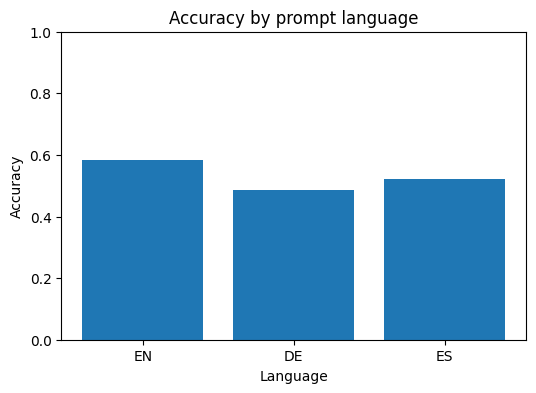

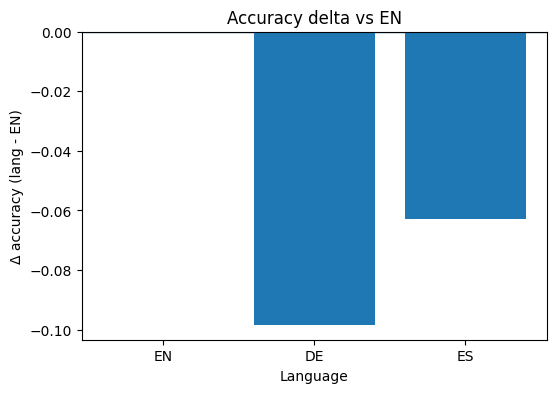

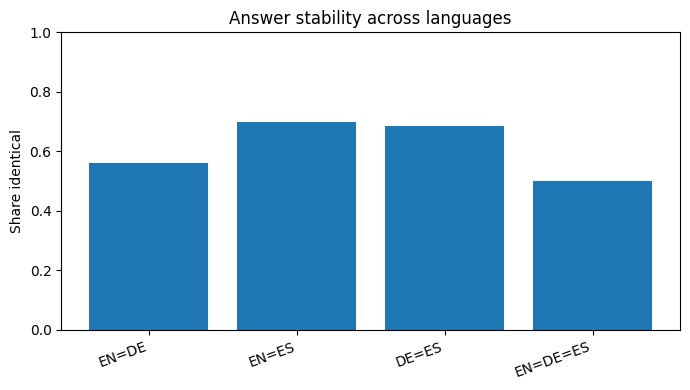

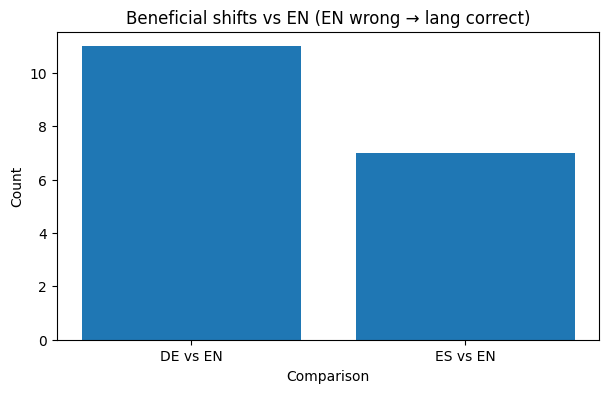

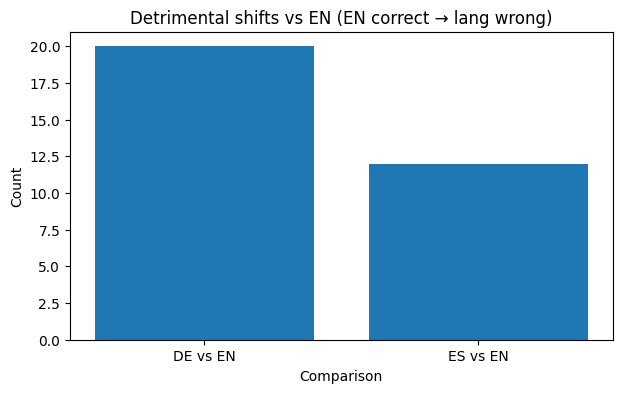

In [68]:
import matplotlib.pyplot as plt

# 8.1 Accuracy per language
plt.figure(figsize=(6,4))
plt.bar(summary["lang"], summary["accuracy"])
plt.ylim(0, 1)
plt.title("Accuracy by prompt language")
plt.ylabel("Accuracy")
plt.xlabel("Language")
plt.show()

# 8.2 Delta vs EN
plt.figure(figsize=(6,4))
plt.bar(summary["lang"], summary["delta_vs_en"])
plt.axhline(0, linewidth=1)
plt.title("Accuracy delta vs EN")
plt.ylabel("Δ accuracy (lang - EN)")
plt.xlabel("Language")
plt.show()

# 8.3 Stability
plt.figure(figsize=(7,4))
plt.bar(stability["pair"], stability["stability"])
plt.ylim(0, 1)
plt.title("Answer stability across languages")
plt.ylabel("Share identical")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# 8.4 Beneficial vs detrimental (relative to EN)
plt.figure(figsize=(7,4))
plt.bar(shifts["comparison"], shifts["beneficial"])
plt.title("Beneficial shifts vs EN (EN wrong → lang correct)")
plt.ylabel("Count")
plt.xlabel("Comparison")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(shifts["comparison"], shifts["detrimental"])
plt.title("Detrimental shifts vs EN (EN correct → lang wrong)")
plt.ylabel("Count")
plt.xlabel("Comparison")
plt.show()

# Eksperyment "Language"
Celem eksperymentu było porównanie zachowania modelu LLaMA-3.1-8B przy identycznych pytaniach wielokrotnego wyboru, zadanych w trzech językach: angielskim (EN), niemieckim (DE) i hiszpańskim (ES). Język angielski pełnił rolę wariantu kontrolnego. Wszystkie w/w języki są według autora oficjalnie wspierane przez model LLaMA-3.1-8B.

Jako dataset posłuzyły skompilowane trzy zbiory pytań CohereLabs Global-MMLU-Lite (EN, DE, ES). Tłumaczenie pytań oraz kontrola jakościbyło dokonywane ręcznie przez autorów datasetu, więc nie mozemy mówić o błędach wynikających z podania pytań o róznym znaczeniu na skutek złego tłumaczenia.

# Przeprowadzono eksperyment porównujący zachowanie modelu dla następujących konfiguracji promptu:

1. Baseline - pytanie i zestaw odpowiedzi podane w języku angielskim

2. DE - pytanie i zestaw odpowiedzi podane w języku niemieckim

3. ES - pytanie i zestaw odpowiedzi podane w języku hiszpańskim

# Dla wariantów osiągnięto następujące rezultaty:

## Accuracy:

- EN	58%	
- DE	49%	(o 9% gorzej niz EN)
- ES	52%	(o 6% gorzej niz EN)

Obserwacje: 
- Najwyższą dokładność model osiąga dla języka angielskiego.
- Spadek jest wyraźnie większy dla języka niemieckiego niż hiszpańskiego.

Interpretaca:
- Spadek jest wyraźnie większy dla języka niemieckiego niż hiszpańskiego.

# Stabilność odpowiedzi pomiędzy językami

- EN=DE   56%
- EN=ES   70%
- DE=ES   68%
- EN=DE=ES   50%

Obserwacje: 
- Identyczną odpowiedź we wszystkich trzech językach otrzymuje 50% pytań
- Najniższa stabilność występuje między EN i DE.
- Odpowiedzi EN–ES są wyraźnie bardziej spójne niż EN–DE.

Interpretacja: 
Zmiana języka promptu często prowadzi do innej odpowiedzi modelu, nawet gdy pytanie i opcje odpowiedzi są semantycznie równoważne. Oznacza to, że model nie posiada jednej, językowo niezmiennej reprezentacji rozwiązania.

# Charakter zmian względem baseline (języka angielskiego)

Porównanie	n	Zmienione	Na lepsze 	Na gorsze
DE vs EN	96	42	        11	        20
ES vs EN	96	29	        7	        12

Obserwacje:
- Zmiana języka częściej szkodzi niż pomaga:
    - Dla języka niemieckiego prawie 2x więcej zmian jest na gorsze (w języku niemieckim odpowiedziano błędnie na pytanie, na które w języku angielskim odpowiedziano poprawnie)
- Język niemiecki powoduje więcej zmian niz hiszpański

Interpretacja:
Zmiana języka nie działa jak losowy szum. W większości przypadków prowadzi do utraty poprawnej odpowiedzi, a nie do jej odzyskania. Oznacza to, że język wpływa na aktywację (lub dezaktywację) właściwej wiedzy w modelu.

# Wnioski

1. LLaMA-3.1-8B nie zachowuje się jak model językowo-agnostyczny. Język promptu istotnie wpływa zarówno na poprawność, jak i stabilność decyzji.

2. LLaMA-3.1-8B nie zachowuje się jak model językowo-agnostyczny. Język promptu istotnie wpływa zarówno na poprawność, jak i stabilność decyzji.

3. Zmiana języka z angielskiego na inny rzadko prowadzi do poprawy, częściej skutkuje utratą poprawnej odpowiedzi. 

